# Comparing Surveyed vs. Estimated Country-means

Ultimately, retrieving the ATE can be seen as determining the (possibly weighted) means of two subsets: treated and control. As we will see, using the mean of model predictions for the subset, $\mathbb{E}[\hat{Y} \mid i \in S]$, will be a biased estimate of $\mathbb{E}[Y \mid i \in S]$ due to $Y - \hat{Y} \not\perp Y$. To study this phenomenon, we would like to estimate the mean of some of subsets with and without our Tweedies' based debiasing formula. The subsets need to be meaningful, so in this notebook we will make use of the country labels to estimate the mean IWI for each country. The hypothesis is that the mean of the predicted estimates will be biased in regards to the true wealth, such that the predicted mean will be too high for poor countries and too low for rich countries. The hope is for the Tweedie's adjusted predictions to remove this bias.

In [1]:
import timm
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

sns.set(style="whitegrid")

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Define the directories for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_top_epochs=0_num_full_epochs=20')
RATLEDGE_MODELS_DIR = os.path.join(DATA_DIR, 'models', 'ratledge_lambda_b=15.0_num_top_epochs=0_num_full_epochs=20')

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with MSE predictions
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

# Load the dataset with Ratledge predictions
if not os.path.exists(RATLEDGE_MODELS_DIR):
    raise FileNotFoundError(f"Ratledge models directory not found at {RATLEDGE_MODELS_DIR}")
ratledge_df = pd.read_csv(os.path.join(RATLEDGE_MODELS_DIR, 'dhs_with_imgs_predictions.csv'))

# Check if the CV folds and Cluster IDs match:
if not (df['cv_fold'] == ratledge_df['cv_fold']).all() or not (df['cluster_id'] == ratledge_df['cluster_id']).all():
    raise ValueError("CV folds in the two datasets do not match.")

# Add the Ratledge predictions to the DHS DataFrame
df['ratledge_iwi_hat'] = ratledge_df['iwi_hat']
del ratledge_df  # Free memory

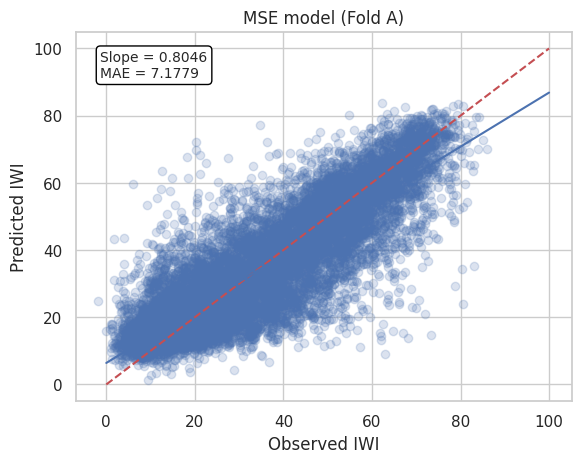

Text(0.5, 1.0, 'MSE model (Fold A)')

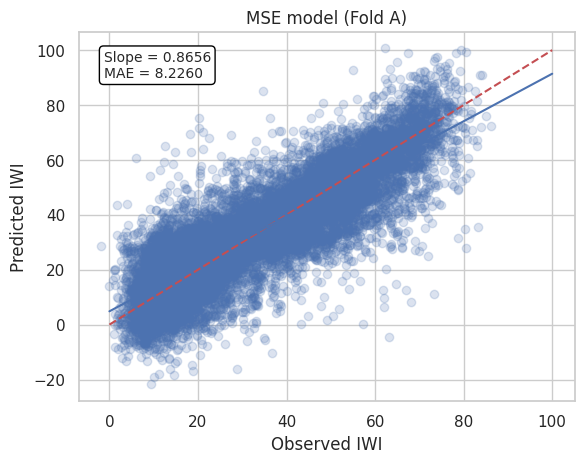

In [17]:
fold = 'A'
fold_df = df[df['cv_fold'] == fold].copy()

fold_df['tweedie_hat'] = fold_df['iwi_hat'] - correction_values[fold]['train_sigma'] ** 2 * fold_df['train_score']

# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(fold_df['iwi'], fold_df['iwi_hat'], alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(fold_df['iwi'], fold_df['iwi_hat'], 1)
mae = mean_absolute_error(fold_df['iwi'], fold_df['iwi_hat'])
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title(f'MSE model (Fold {fold})')
plt.show()

# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(fold_df['iwi'], fold_df['tweedie_hat'], alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(fold_df['iwi'], fold_df['tweedie_hat'], 1)
mae = mean_absolute_error(fold_df['iwi'], fold_df['tweedie_hat'])
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title(f'MSE model (Fold {fold})')

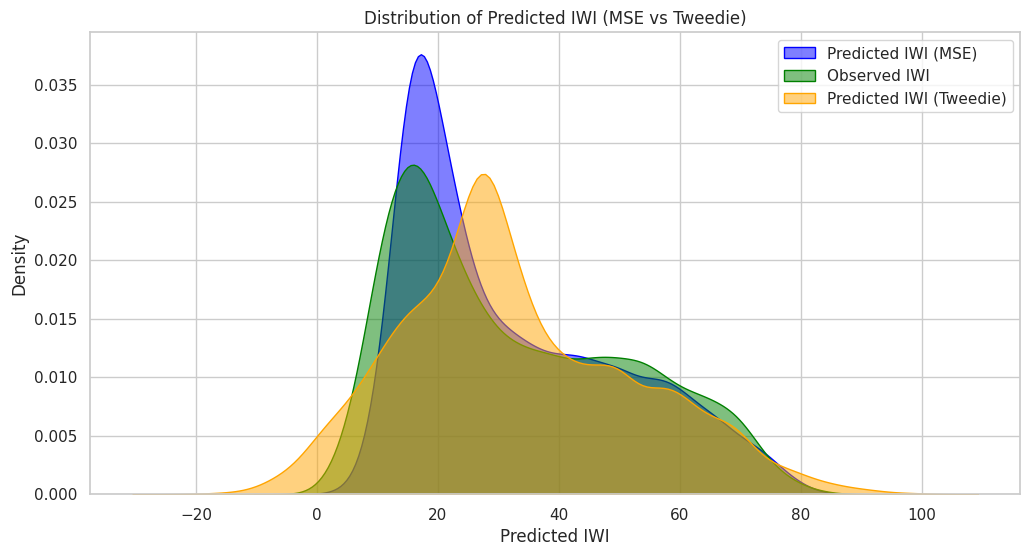

In [18]:
# Plot distribution of iwi_hat vs tweedie_hat
plt.figure(figsize=(12, 6))
sns.kdeplot(fold_df['iwi_hat'], label='Predicted IWI (MSE)', color='blue', fill=True, alpha=0.5)
sns.kdeplot(fold_df['iwi'], label='Observed IWI', color='green', fill=True, alpha=0.5)
sns.kdeplot(fold_df['tweedie_hat'], label='Predicted IWI (Tweedie)', color='orange', fill=True, alpha=0.5)
plt.xlabel('Predicted IWI')
plt.ylabel('Density')
plt.title('Distribution of Predicted IWI (MSE vs Tweedie)')
plt.legend()
plt.show()

In [35]:
def get_survey_means(survey_df, correction_values):

    survey_means = survey_df.groupby('cv_fold')[['iwi', 'iwi_hat', 'val_score', 'train_score', 'ratledge_iwi_hat']].mean().sort_values('cv_fold')

    for i, row in survey_means.iterrows():
        fold_corr_vals = correction_values[row.name]
        survey_means.loc[row.name, 'lcc_val_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['val_lcc_intercept']) / fold_corr_vals['val_lcc_slope']
        survey_means.loc[row.name, 'lcc_train_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['train_lcc_intercept']) / fold_corr_vals['train_lcc_slope']

        survey_means.loc[row.name, 'tweedie_train_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['train_score']
        survey_means.loc[row.name, 'tweedie_val_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['val_sigma'] ** 2 * row['val_score']
        survey_means.loc[row.name, 'tweedie_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['val_score']

    survey_means = survey_means.drop(columns=['val_score', 'train_score'])

    return survey_means

survey_means_df = df.groupby('survey').apply(get_survey_means, correction_values=correction_values).reset_index()

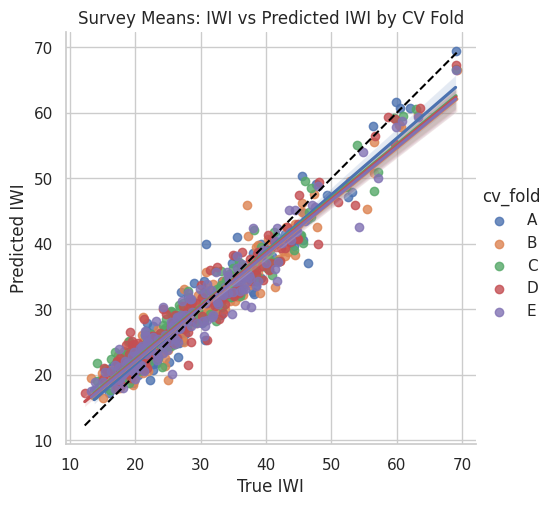

In [10]:
sns.lmplot(data=survey_means_df, x='iwi', y='iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs Predicted IWI by CV Fold')
plt.show()

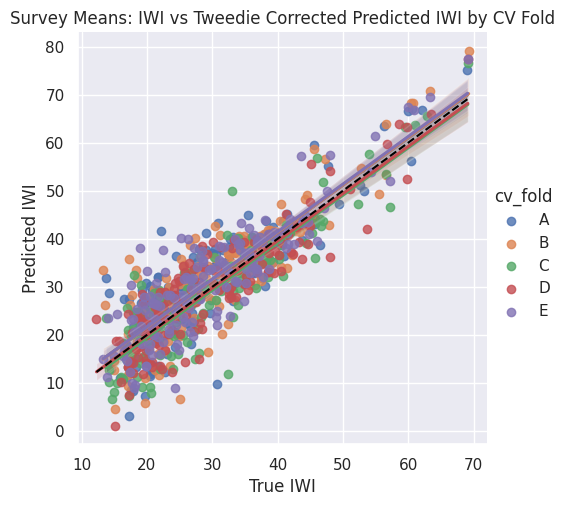

In [5]:
sns.lmplot(data=survey_means_df, x='iwi', y='tweedie_val_iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs Tweedie Corrected Predicted IWI by CV Fold')
plt.show()

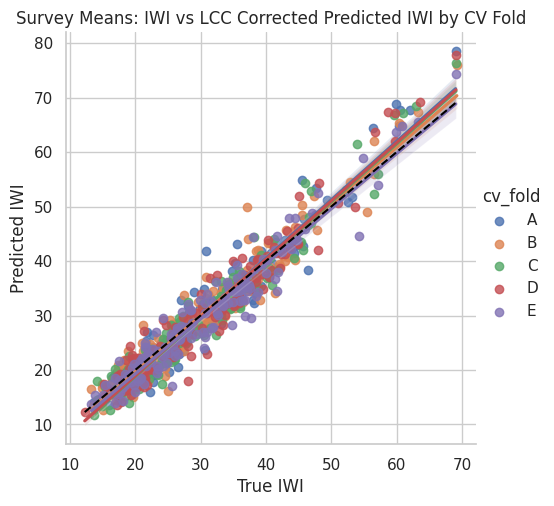

In [9]:
sns.lmplot(data=survey_means_df, x='iwi', y='lcc_val_iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs LCC Corrected Predicted IWI by CV Fold')
plt.show()

In [36]:
long_df = pd.melt(
    survey_means_df,
    id_vars=['survey', 'cv_fold', 'iwi'],
    value_vars=['iwi_hat', 'lcc_val_iwi_hat', 'lcc_train_iwi_hat', 'tweedie_train_iwi_hat', 'tweedie_val_iwi_hat', 'tweedie_iwi_hat'],
    var_name='pred_type',
    value_name='value'
)

long_df

,survey,cv_fold,iwi,pred_type,value
0,Angola 2006-07 MIS,A,30.650841,iwi_hat,25.346797
1,Angola 2006-07 MIS,B,29.294907,iwi_hat,27.982683
2,Angola 2006-07 MIS,C,27.339045,iwi_hat,30.937161
3,Angola 2006-07 MIS,D,23.851853,iwi_hat,26.458127
4,Angola 2006-07 MIS,E,24.296925,iwi_hat,23.309042
...,...,...,...,...,...
4933,Zimbabwe 2015 Standard DHS,A,38.051273,tweedie_iwi_hat,36.717611
4934,Zimbabwe 2015 Standard DHS,B,39.035836,tweedie_iwi_hat,33.382184
4935,Zimbabwe 2015 Standard DHS,C,38.500091,tweedie_iwi_hat,34.810787
4936,Zimbabwe 2015 Standard DHS,D,39.610608,tweedie_iwi_hat,34.799020


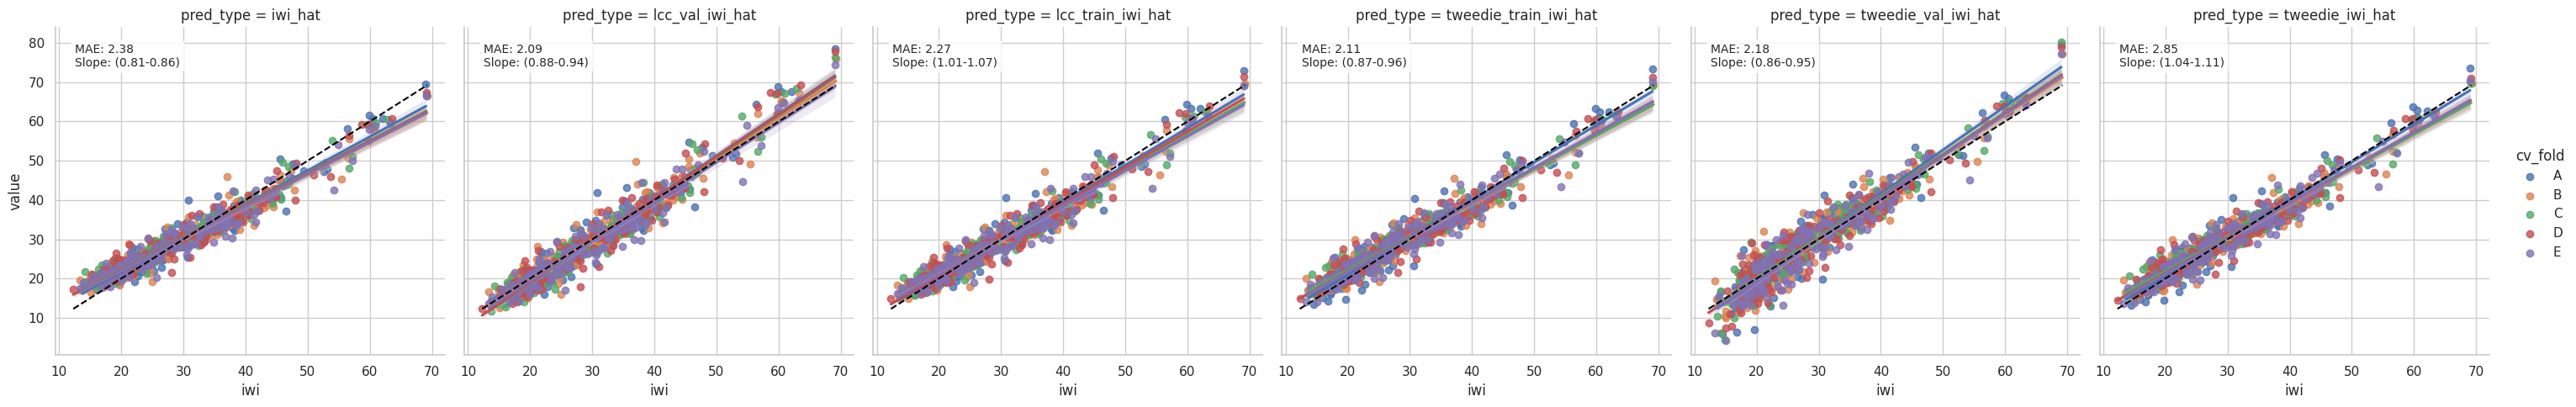

In [11]:
# Calculate MAE and mean slope for each pred_type and cv_fold
metrics = long_df.groupby(['pred_type', 'cv_fold']).apply(
    lambda group: pd.Series({
        'mae': mean_absolute_error(group['iwi'], group['value']),
        'slope': LinearRegression().fit(group[['iwi']], group['value']).coef_[0]
    })
).reset_index()

# Add the metrics to the plots
g = sns.lmplot(
    data=long_df, x="iwi", y="value",
    hue="cv_fold", col="pred_type", height=5,
    facet_kws=dict(sharex=True, sharey=True),
)

# Add the dashed line to all subplots and annotate metrics
for ax, (pred_type, group) in zip(g.axes.flat, metrics.groupby('pred_type')):
    ax.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
    mae = group['mae'].mean()
    min_slope = group['slope'].min()
    max_slope = group['slope'].max()
    ax.text(
        0.05, 0.95, f"MAE: {mae:.2f}\nSlope: ({min_slope:.2f}-{max_slope:.2f})",
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

plt.show()

In [37]:
survey_means_agg_df = survey_means_df.groupby(['survey']).mean().reset_index()
survey_means_agg_df

,survey,iwi,iwi_hat,ratledge_iwi_hat,lcc_val_iwi_hat,lcc_train_iwi_hat,tweedie_train_iwi_hat,tweedie_val_iwi_hat,tweedie_iwi_hat
0,Angola 2006-07 MIS,27.086714,26.806762,16.279773,25.214074,26.002867,24.736793,19.658218,24.513506
1,Angola 2011 MIS,29.386719,33.346660,30.438205,33.469002,33.197862,32.085597,29.064753,31.939970
2,Angola 2015-16 Standard DHS,35.200058,35.513204,33.258169,36.219313,35.550692,35.212573,34.066996,35.080773
3,Benin 1996 Standard DHS,17.909767,20.350364,19.224794,17.000400,18.913710,20.513385,19.776917,20.053465
4,Benin 2001 Standard DHS,25.811657,28.634370,29.154697,27.498974,27.999607,29.530114,30.461369,29.253920
...,...,...,...,...,...,...,...,...,...
160,Zambia 2018 Standard DHS,28.725330,28.911376,27.185311,27.841885,28.306623,28.499620,26.896243,28.242231
161,Zimbabwe 1999 Standard DHS,28.450789,32.306847,31.469392,32.110045,32.013286,33.031351,33.815849,32.822716
162,Zimbabwe 2005-06 Standard DHS,27.632550,29.865300,28.322905,29.052408,29.360797,30.289120,30.336585,30.023347
163,Zimbabwe 2010-11 Standard DHS,34.464338,31.547922,29.421483,31.188998,31.200403,31.838994,31.655875,31.603373


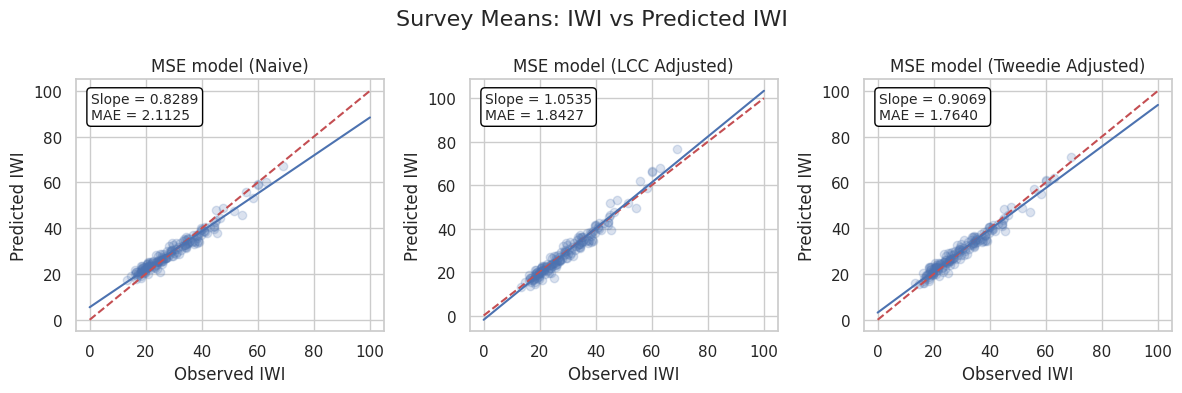

In [ ]:
# Plot the ATEs
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(survey_means_agg_df['iwi'], survey_means_agg_df['iwi_hat'], alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(survey_means_agg_df['iwi'], survey_means_agg_df['iwi_hat'], 1)
mae = mean_absolute_error(survey_means_agg_df['iwi'], survey_means_agg_df['iwi_hat'])
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('MSE model (Naive)')

plt.subplot(1, 3, 2)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(survey_means_agg_df['iwi'], survey_means_agg_df['lcc_val_iwi_hat'], alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(survey_means_agg_df['iwi'], survey_means_agg_df['lcc_val_iwi_hat'], 1)
mae = mean_absolute_error(survey_means_agg_df['iwi'], survey_means_agg_df['lcc_val_iwi_hat'])
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('MSE model (LCC Adjusted)')

plt.subplot(1, 3, 3)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(survey_means_agg_df['iwi'], survey_means_agg_df['tweedie_iwi_hat'], alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(survey_means_agg_df['iwi'], survey_means_agg_df['tweedie_iwi_hat'], 1)
mae = mean_absolute_error(survey_means_agg_df['iwi'], survey_means_agg_df['tweedie_iwi_hat'])
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('MSE model (Tweedie Adjusted)')
plt.suptitle('Survey Means: IWI vs Predicted IWI', fontsize=16)
plt.tight_layout()

plt.savefig('figures/simulated_ate_estimates.png', bbox_inches='tight', dpi=300)

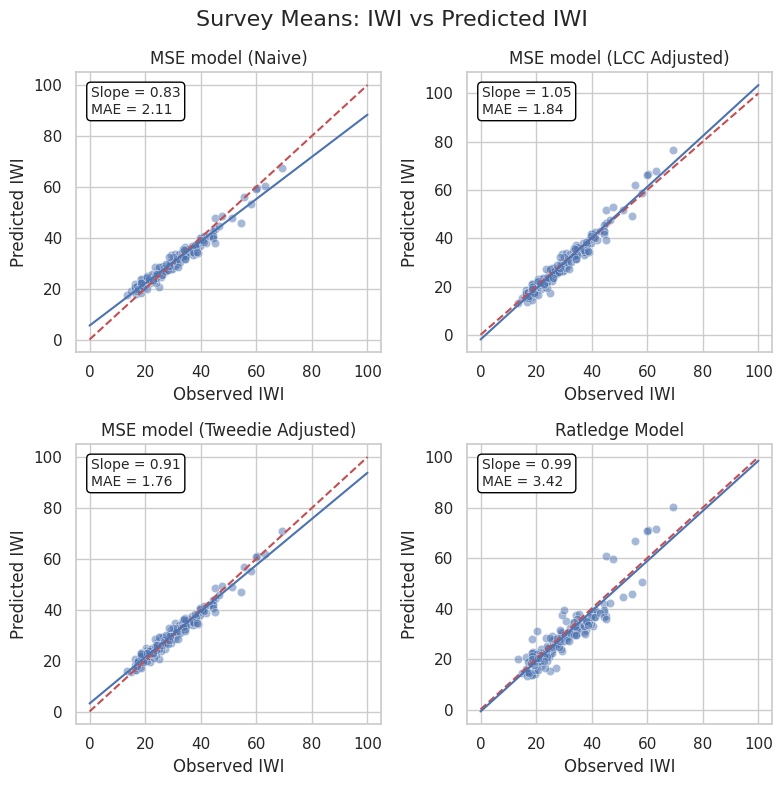

In [46]:
def plot_group_means(group_means_df, pred_type, title):
    sns.scatterplot(data=group_means_df, x='iwi', y=pred_type, alpha=0.5)
    slope, _ = np.polyfit(group_means_df['iwi'], group_means_df[pred_type], 1)
    mae = mean_absolute_error(group_means_df['iwi'], group_means_df[pred_type])
    plt.text(0.05, 0.95, f'Slope = {slope:.2f}\nMAE = {mae:.2f}', transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.plot([0, 100], [0, 100], 'r--')
    plt.plot([0, 100], [_, _ + slope * 100])  # Adjusted line based on slope and intercept
    plt.xlabel('Observed IWI')
    plt.ylabel('Predicted IWI')
    plt.title(title)

plot_df = survey_means_df.groupby(['survey']).mean().reset_index()

# Plot ADM2 means for each prediction type
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_adm2_means(plot_df, 'iwi_hat', 'MSE model (Naive)')
plt.subplot(2, 2, 2)
plot_adm2_means(plot_df, 'lcc_val_iwi_hat', 'MSE model (LCC Adjusted)')
plt.subplot(2, 2, 3)
plot_adm2_means(plot_df, 'tweedie_iwi_hat', 'MSE model (Tweedie Adjusted)')
plt.subplot(2, 2, 4)
plot_adm2_means(plot_df, 'ratledge_iwi_hat', 'Ratledge Model')
plt.suptitle('Survey Means: IWI vs Predicted IWI', fontsize=16)
plt.tight_layout()

plt.savefig('figures/survey_estimates.png', bbox_inches='tight', dpi=300)

## Admin 2 regions

In [39]:
adm2_means_df = df.groupby('region_id').apply(get_survey_means, correction_values=correction_values).reset_index()

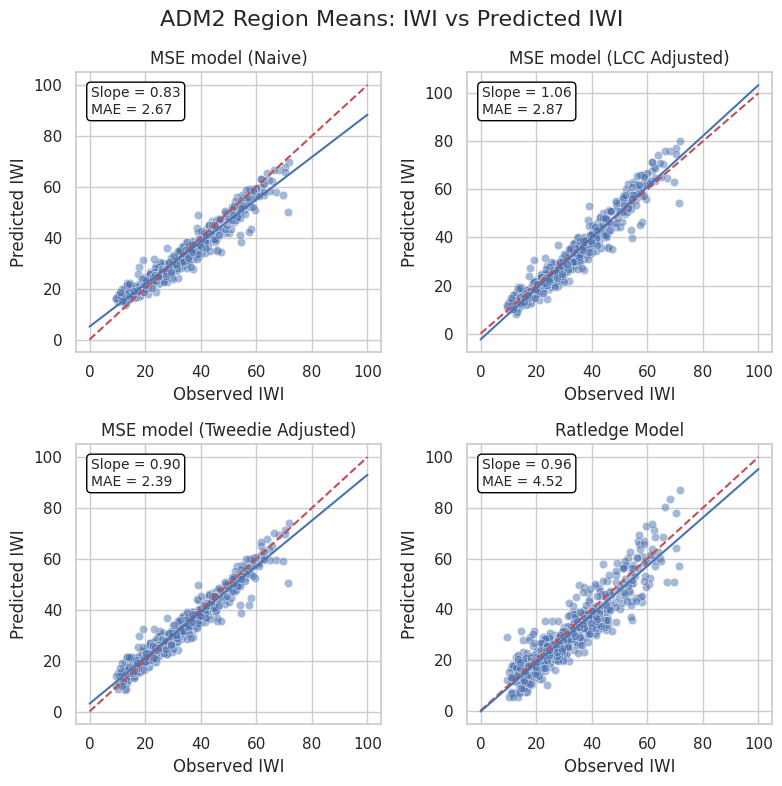

In [ ]:
plot_df = adm2_means_df.groupby(['region_id']).mean().reset_index()
plot_df['n_samples'] = df.groupby('region_id').size().values
#plot_df = plot_df[plot_df['n_samples'] >= 100]  # Filter out regions with fewer than 100 samples

# Plot ADM2 means for each prediction type
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_group_means(plot_df, 'iwi_hat', 'MSE model (Naive)')
plt.subplot(2, 2, 2)
plot_group_means(plot_df, 'lcc_val_iwi_hat', 'MSE model (LCC Adjusted)')
plt.subplot(2, 2, 3)
plot_group_means(plot_df, 'tweedie_iwi_hat', 'MSE model (Tweedie Adjusted)')
plt.subplot(2, 2, 4)
plot_group_means(plot_df, 'ratledge_iwi_hat', 'Ratledge Model')
plt.suptitle('ADM2 Region Means: IWI vs Predicted IWI', fontsize=16)
plt.tight_layout()

plt.savefig('figures/adm2_estimates.png', bbox_inches='tight', dpi=300)

## Don't use swap

What do the predictions look like if we use the scores from the true value $y$ instead of $\hat{y}$?

In [4]:
from scipy.stats import gaussian_kde

folds = ['A', 'B', 'C', 'D', 'E']

true_kdes = {}

for fold in folds:
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    true_kdes[fold] = gaussian_kde(df[df['cv_fold'].isin(train_folds)]['iwi'])

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

df['true_score'] = df.progress_apply(lambda row: score_function(row['iwi'], true_kdes[row['cv_fold']]), axis=1)

100%|██████████| 68619/68619 [06:12<00:00, 184.34it/s]


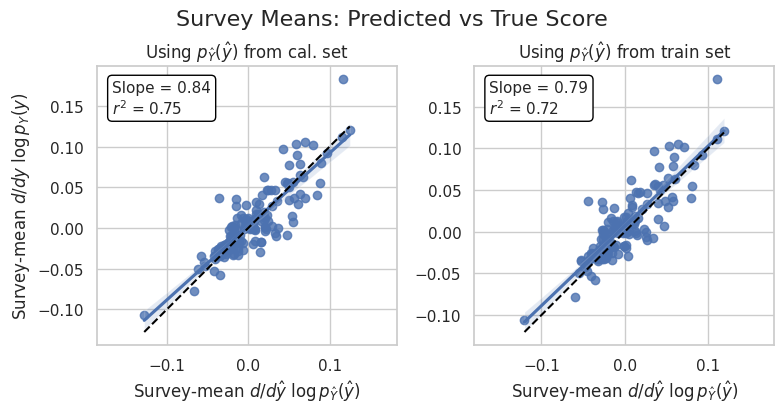

In [12]:
mean_survey_scores_df = df.groupby('survey')[['val_score', 'train_score', 'true_score']].mean().reset_index()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.regplot(x='val_score', y='true_score', data=mean_survey_scores_df)
plt.xlabel(r'Survey-mean $d / d\hat{y}$ $\log p_\hat{Y}(\hat{y})$')
plt.ylabel(r'Survey-mean $d / dy$ $\log p_Y(y)$')
plt.title(r'Using $p_\hat{Y}(\hat{y})$ from cal. set')
min_val_score = mean_survey_scores_df['val_score'].min()
max_val_score = mean_survey_scores_df['val_score'].max()
plt.plot([min_val_score, max_val_score], [min_val_score, max_val_score], color='black', linestyle='--')
# Add label with slope and R^2 to plot
slope, _ = np.polyfit(mean_survey_scores_df['true_score'], mean_survey_scores_df['val_score'], 1)
r2 = r2_score(mean_survey_scores_df['true_score'], mean_survey_scores_df['val_score'])
plt.text(0.05, 0.95, f'Slope = {slope:.2f}\n$r^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.axis('equal')

plt.subplot(1, 2, 2)
sns.regplot(x='train_score', y='true_score', data=mean_survey_scores_df)
plt.xlabel(r'Survey-mean $d / d\hat{y}$ $\log p_\hat{Y}(\hat{y})$')
plt.ylabel('')
plt.title(r'Using $p_\hat{Y}(\hat{y})$ from train set')
min_train_score = mean_survey_scores_df['train_score'].min()
max_train_score = mean_survey_scores_df['train_score'].max()
plt.plot([min_train_score, max_train_score], [min_train_score, max_train_score], color='black', linestyle='--')
# Add label with slope and R^2 to plot
slope, _ = np.polyfit(mean_survey_scores_df['true_score'], mean_survey_scores_df['train_score'], 1)
r2 = r2_score(mean_survey_scores_df['true_score'], mean_survey_scores_df['train_score'])
plt.text(0.05, 0.95, f'Slope = {slope:.2f}\n$r^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.axis('equal')
plt.tight_layout()
plt.suptitle('Survey Means: Predicted vs True Score', fontsize=16, y=1.03)
plt.show()

Text(0.5, 1.0, 'Training Scores vs True IWI Scores')

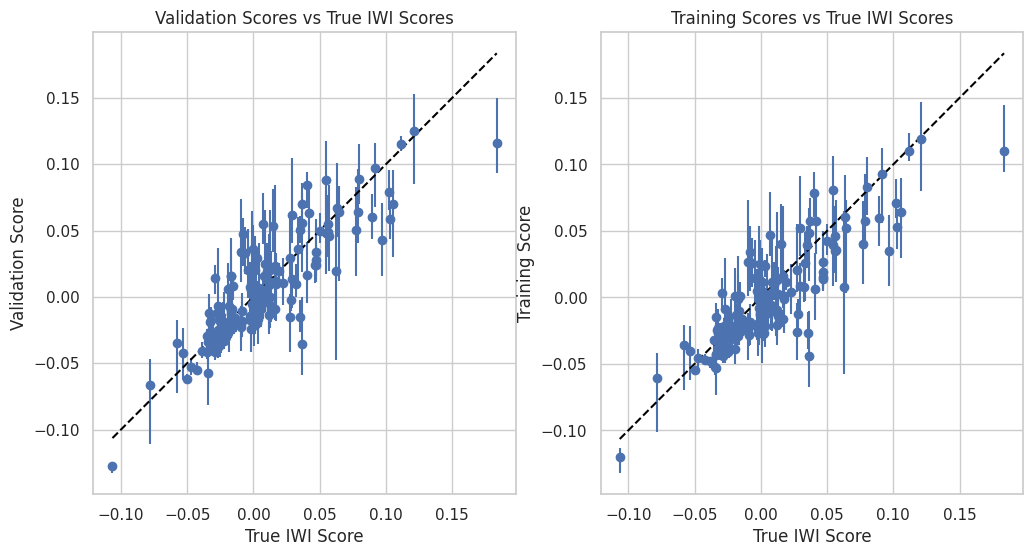

In [29]:
mean_survey_fold_scores_df = df.groupby(['survey', 'cv_fold'])[['val_score', 'train_score']].mean().reset_index()
res_df = mean_survey_fold_scores_df.groupby('survey').agg({
    'val_score': ['min', 'max'],
    'train_score': ['min', 'max']
}).reset_index()

res_df.columns = ['survey', 'val_score_min', 'val_score_max', 'train_score_min', 'train_score_max']
res_df['val_score'] = df.groupby('survey')['val_score'].mean().values
res_df['train_score'] = df.groupby('survey')['train_score'].mean().values
res_df['true_scores'] = df.groupby('survey')['true_score'].mean().values

# Make two plots with results. The first has true scores on the x-axis and validation scores (with error bars) on the y-axis.
# The second has true scores on the x-axis and training scores (with error bars) on the y-axis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(res_df['true_scores'], res_df['val_score'], 
             yerr=[res_df['val_score'] - res_df['val_score_min'], res_df['val_score_max'] - res_df['val_score']],
             fmt='o', label='Validation Score')
min_true_score = res_df['true_scores'].min()
max_true_score = res_df['true_scores'].max()
plt.plot([min_true_score, max_true_score], [min_true_score, max_true_score], color='black', linestyle='--')
plt.xlabel('True IWI Score')
plt.ylabel('Validation Score')
plt.title('Validation Scores vs True IWI Scores')
plt.subplot(1, 2, 2)
plt.errorbar(res_df['true_scores'], res_df['train_score'], 
             yerr=[res_df['train_score'] - res_df['train_score_min'], res_df['train_score_max'] - res_df['train_score']],
             fmt='o', label='Training Score')
plt.plot([min_true_score, max_true_score], [min_true_score, max_true_score], color='black', linestyle='--')
plt.xlabel('True IWI Score')
plt.ylabel('Training Score')
plt.title('Training Scores vs True IWI Scores')

## Compare with PPI

In [6]:
def get_survey_PPI_mean(survey_df, hold_out_frac=0.01):

    # Get a sample contaiing hold_out_frac of the data for each cv_fold
    hold_out_survey_df = survey_df.groupby('cv_fold').apply(
        lambda x: x.sample(frac=hold_out_frac, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    hold_out_survey_df['residual'] = hold_out_survey_df['iwi'] - hold_out_survey_df['iwi_hat']
    mean_residuals = hold_out_survey_df.groupby('cv_fold')['residual'].mean()

    survey_means = survey_df.groupby('cv_fold')[['iwi', 'iwi_hat']].mean().sort_values('cv_fold')
    survey_means['ppi_iwi_hat'] = survey_means['iwi_hat'] + mean_residuals
    survey_means = survey_means.drop(columns=['iwi_hat'])

    survey_means['hold_out_frac'] = hold_out_frac
    survey_means['hold_out_samples'] = hold_out_survey_df.groupby('cv_fold').size()
    return survey_means
    

In [7]:
hold_out_fracs = np.linspace(0.01, 1.0, 50)

ppi_stats = []

for frac in tqdm(hold_out_fracs):
    survey_ppi_means_df = df.groupby('survey').apply(get_survey_PPI_mean, hold_out_frac=frac).reset_index()

    n_surveys = survey_ppi_means_df['survey'].nunique()

    survey_ppi_means_df.dropna(inplace=True)

    ppi_metrics = survey_ppi_means_df.groupby('cv_fold').apply(
        lambda group: pd.Series({
            'mae': mean_absolute_error(group['iwi'], group['ppi_iwi_hat']),
            'slope': LinearRegression().fit(group[['iwi']], group['ppi_iwi_hat']).coef_[0],
            'hold_out_frac': frac,
            'n_dropped_surveys': n_surveys - group['survey'].nunique(),
        })
    ).reset_index()

    ppi_stats.append(ppi_metrics)
    
ppi_stats_df = pd.concat(ppi_stats, ignore_index=True)
ppi_stats_df

100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


,cv_fold,mae,slope,hold_out_frac,n_dropped_surveys
0,A,5.837203e+00,0.959169,0.01,52.0
1,B,6.699189e+00,0.998755,0.01,58.0
2,C,5.720719e+00,0.985000,0.01,52.0
3,D,5.901200e+00,0.990314,0.01,50.0
4,E,6.475814e+00,1.070247,0.01,49.0
...,...,...,...,...,...
245,A,2.368476e-15,1.000000,1.00,0.0
246,B,2.013204e-15,1.000000,1.00,0.0
247,C,1.959375e-15,1.000000,1.00,0.0
248,D,1.700537e-15,1.000000,1.00,1.0


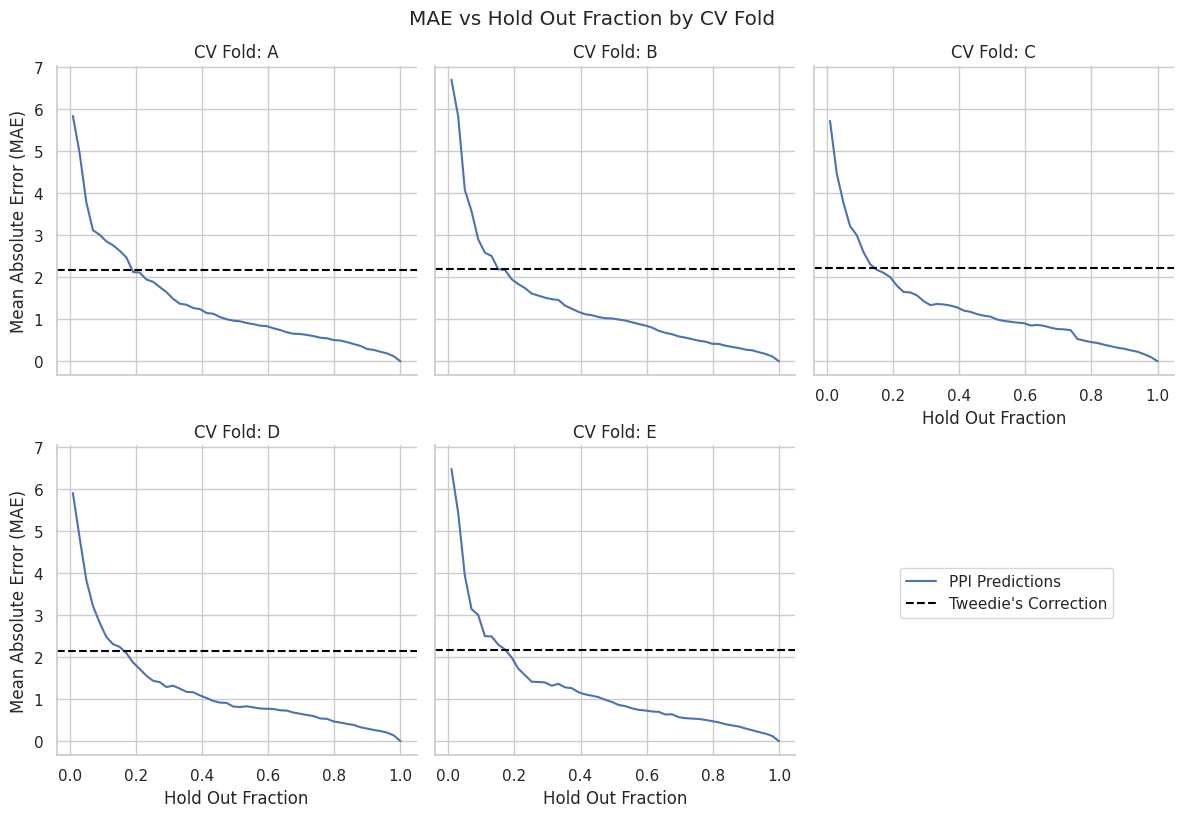

In [12]:
g = sns.FacetGrid(ppi_stats_df, col="cv_fold", col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, "hold_out_frac", "mae")

# Add dashed horizontal lines for tweedie_train_iwi_hat MAE
for ax, cv_fold in zip(g.axes.flat, ppi_stats_df['cv_fold'].unique()):
    mae_value = metrics[(metrics['cv_fold'] == cv_fold) & (metrics['pred_type'] == 'tweedie_train_iwi_hat')]['mae'].values[0]
    ax.axhline(mae_value, color='black', linestyle='--', label='Tweedie Train MAE')

ppi_line_color = g.axes[0].lines[0].get_color()

# Create custom legend handles using actual line colors
custom_lines = [
    Line2D([0], [0], color=ppi_line_color, linestyle='-', label='PPI Predictions'),
    Line2D([0], [0], color='black', linestyle='--', label="Tweedie's Correction")
]

# Set labels and titles
g.set_axis_labels("Hold Out Fraction", "Mean Absolute Error (MAE)")
g.set_titles("CV Fold: {col_name}")
g.fig.suptitle("MAE vs Hold Out Fraction by CV Fold", y=1.02)

# Add custom legend to the figure
g.fig.legend(handles=custom_lines, loc='lower left', bbox_to_anchor=(0.75, 0.25))
plt.show()


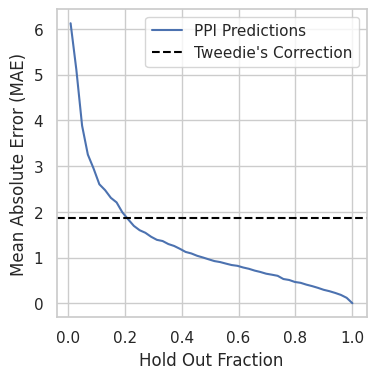

In [ ]:
plt.figure(figsize=(4, 4))

# Aggregate the data by pred_type
aggregated_ppi_stats = ppi_stats_df.groupby('hold_out_frac').agg(
    mae=('mae', 'mean'),
    slope=('slope', 'mean')
).reset_index()

# Plot MAE
sns.lineplot(data=aggregated_ppi_stats, x='hold_out_frac', y='mae')

mae_value = mean_absolute_error(survey_means_agg_df['iwi'], survey_means_agg_df['tweedie_train_iwi_hat'])
plt.axhline(mae_value, color='black', linestyle='--', label='Tweedie Train MAE')

# Create custom legend handles using actual line colors
custom_lines = [
    Line2D([0], [0], color=ppi_line_color, linestyle='-', label='PPI Predictions'),
    Line2D([0], [0], color='black', linestyle='--', label="Tweedie's Correction")
]

plt.legend(handles=custom_lines)
plt.xlabel('Hold Out Fraction')
plt.ylabel('Mean Absolute Error (MAE)')

# Add a title and legend
# plt.title('Aggregated MAE and Slope vs Hold Out Fraction')
plt.show()

# Save figure as ppi_vs_tweedie.png
# plt.savefig('ppi_vs_tweedie.png', bbox_inches='tight', dpi=300)

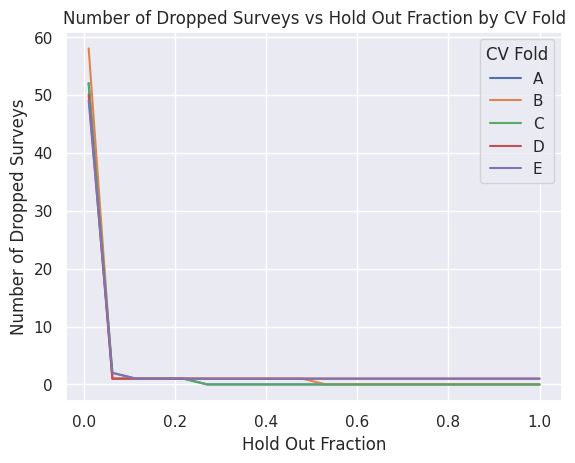

In [15]:
sns.lineplot(data=ppi_stats_df, x='hold_out_frac', y='n_dropped_surveys', hue='cv_fold')
plt.xlabel('Hold Out Fraction')
plt.ylabel('Number of Dropped Surveys')
plt.title('Number of Dropped Surveys vs Hold Out Fraction by CV Fold')
plt.legend(title='CV Fold')
plt.show()

In [16]:
metrics

,pred_type,cv_fold,mae,slope
0,iwi_hat,A,2.270104,0.860984
1,iwi_hat,B,2.275988,0.848135
2,iwi_hat,C,2.316853,0.877968
3,iwi_hat,D,2.347381,0.822339
4,iwi_hat,E,2.241685,0.851451
5,lcc_train_iwi_hat,A,2.048806,0.889561
6,lcc_train_iwi_hat,B,2.082678,0.901531
7,lcc_train_iwi_hat,C,2.175310,0.888037
8,lcc_train_iwi_hat,D,2.169614,0.859163
9,lcc_train_iwi_hat,E,2.194351,0.868064
